In [1]:
from forge import Forge

In [2]:
mdf = Forge()

In [4]:
mdf.search_by_elements("Al", "Cr", "U", "Fe", "C", match_all=False)

[{'mdf': {'collection': 'OQMD',
   'composition': 'Cr1Fe1U1',
   'elements': ['Fe', 'Cr', 'U'],
   'ingest_date': '2017-07-12T19:17:16.525611Z',
   'links': {'landing_page': 'http://oqmd.org/analysis/calculation/2092714',
    'metadata': {'globus_endpoint': '82f1b5c6-6e9b-11e5-ba47-22000b92c6ec',
     'http_host': 'https://data.materialsdatafacility.org',
     'path': '/collections/oqmd/data/home/oqmd/libraries/prototypes/ternaries/half_heusler/Cr/Fe_U/static/metadata.json'},
    'outcar': {'globus_endpoint': '82f1b5c6-6e9b-11e5-ba47-22000b92c6ec',
     'http_host': 'https://data.materialsdatafacility.org',
     'path': '/collections/oqmd/data/home/oqmd/libraries/prototypes/ternaries/half_heusler/Cr/Fe_U/static'},
    'parent_id': '596670e4f2c0041b5cbb00aa'},
   'mdf-id': '596675bcf2c0041b5cbc66eb',
   'metadata_version': '0.3.0',
   'resource_type': 'record',
   'scroll_id': 91713,
   'source_name': 'oqmd',
   'title': 'OQMD - Cr1Fe1U1'},
  'oqmd': {'band_gap': 0.0,
   'configuration'

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import matplotlib

import base_style
sns.set_style("white", base_style.base_style)
sns.set_context("talk", font_scale=1.5)

%matplotlib inline

import globus_auth

In [122]:
def get_vectors(data):
     for key in data:
        return (data[key]['content'].get('composition#comp', None), 
                data[key]['content'].get('http://www.oqmd.org#delta_e', None),
                data[key]['content'].get('http://www.oqmd.org#energy_pa', None),
                data[key]['content'].get('http://www.oqmd.org#volume_pa', None),
                data[key]['content'].get('http://www.oqmd.org#magmom_pa', None),
                data[key]['content'].get('http://www.oqmd.org#stability', None),
                data[key]['content'].get('http://www.oqmd.org#bandgap',None)) 

# Authenticate Search Client
Uses a valid authentication token if it exists, redirects to web if not

In [123]:
client = globus_auth.login("https://datasearch.api.demo.globus.org/")

# Search for Data and Aggregate into a DataFrame

In [124]:
params = {
        'q': "JANAF",
        'highlight': True,
        'resource_type': None,
        'count': 20,
        'from': 0,
        'stats': True,
        'facets': None,
        'filters': None,
    }
    
r = client.search(**params)
print("Found %d results"%(r.data['gstats']['total']))

KeyError: 'gstats'

# Aggregate a Larger Query

In [125]:
n_records = 1650
offset = 0
vectors = []

for i in range(0,5):
    params = { 'q': "OQMD",
               'count': n_records,
               'from': i*n_records}

    r = client.search(**params)
    result_iterator = r.data['gmeta']
    for result in result_iterator:
        vectors.append(get_vectors(result))

df = pd.DataFrame(vectors, columns=["composition", "delta_e", 
                                    "energy_pa", "volume_pa", 
                                    "magmom_pa","stability", "bandgap"])


# Example Output

In [127]:
print(json.dumps(r.data['gmeta'][1], sort_keys=True, indent=4))

{
    "http://oqmd.org/materials/entry/363255": {
        "content": {
            "composition#comp": "Lu1Pt2Sm1",
            "http://dublincore.org/documents/dcmi-terms#title": "OQMD - Lu1Pt2Sm1",
            "http://www.oqmd.org#bandgap": 0.0,
            "http://www.oqmd.org#delta_e": -1.177739863125,
            "http://www.oqmd.org#energy_pa": -6.515356935,
            "http://www.oqmd.org#id": "363255",
            "http://www.oqmd.org#stability": 0.0915803743750001,
            "http://www.oqmd.org#volume_pa": 20.8716
        },
        "mimetype": "application/json"
    }
}


# Visualize the Results 

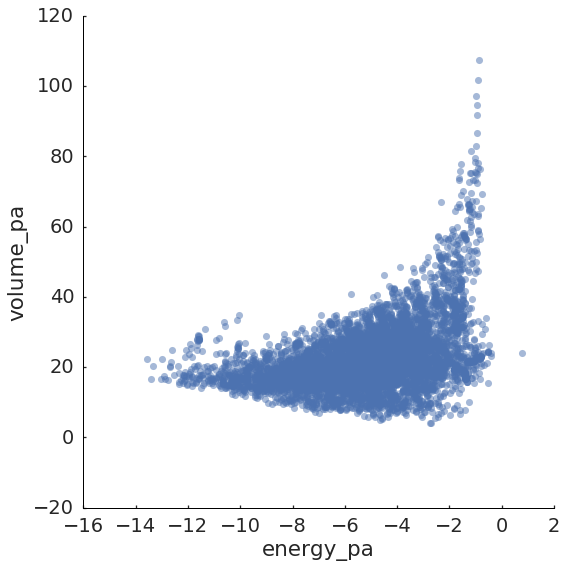

In [108]:
pal = sns.color_palette("muted")

x_col = "energy_pa"
y_col = "volume_pa"


# Make plot
g = sns.lmplot(x=x_col, y=y_col, data=df, fit_reg=False,
               palette=df['bandgap'].apply(lambda x: get_plot_color(x)), size=8, scatter_kws={"s": 50, 
                                                 "alpha": 0.5})

# Set axis labels
g.set_axis_labels(x_col,y_col)

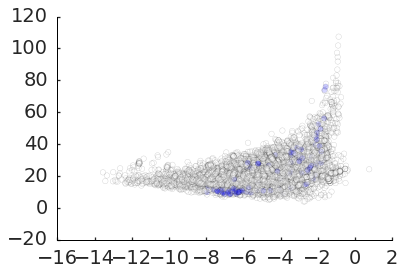

In [112]:
plt.style.context('fivethirtyeight')
fig, ax = plt.subplots()

def get_plot_color(property):
    if np.abs(property) == 0:
        return "white"
    else:
        return "blue"

ax.scatter(df[x_col], df[y_col], s=30, c=df['bandgap'].apply(lambda x: get_plot_color(x)), alpha=0.2 )
sns.despine()

plt.show()

# JANAF Example
* http://kinetics.nist.gov/janaf/
* e.g., Search Na2

In [26]:
def get_janaf_vector(data, index, fields=['composition#comp','http://kinetics.nist.gov/janaf#Cp','http://kinetics.nist.gov/janaf#T']):
    result = []
    for key in data:
        for field in fields:
            result.append(data[key]['content'].get(field, None))

    return result

In [27]:
n_records = 30
offset=10

vectors = []

for i in range(1):
    params = {
        'q': "JANAF",
        #'highlight': args.highlight,
        #'resource_type': args.resource_type,
        'count': n_records,
        'from': n_records*i+offset,
        #'stats': args.stats,
        #'facets': args.facets,
        #'filters': args.filters,
        #'boost': args.boost
    }
    
    janaf_vectors = []
    r = client.search(**params)
    for result in r.data['gmeta']:
        janaf_vectors.append(get_janaf_vector(result, 2))

df_janaf = pd.DataFrame(janaf_vectors, columns=["Composition", "Cp","T"])
composition,Cp,T = df_janaf.ix[1]
df_t = pd.DataFrame({"Cp":Cp, "T":T})

In [28]:
df_janaf.head()

,Composition,Cp,T
0,AlOH+,"[33.535, 33.616, 35.837, 37.986, 39.947, 41.68...","[298.15, 300.0, 350.0, 400.0, 450.0, 500.0, 60..."
1,AlOH-,"[36.521, 36.578, 38.106, 39.556, 40.861, 42.00...","[298.15, 300.0, 350.0, 400.0, 450.0, 500.0, 60..."
2,OAlOH,"[0.0, 34.495, 42.414, 46.534, 50.137, 50.267, ...","[0.0, 100.0, 200.0, 250.0, 298.15, 300.0, 350...."
3,LiAlH4,"[86.4, 86.944, 93.722, 101.253, 106.901, 111.2...","[298.15, 300.0, 400.0, 500.0, 600.0, 700.0, 80..."
4,AlI,"[0.0, 31.012, 34.703, 35.586, 36.127, 36.144, ...","[0.0, 100.0, 200.0, 250.0, 298.15, 300.0, 350...."


# Make Plot

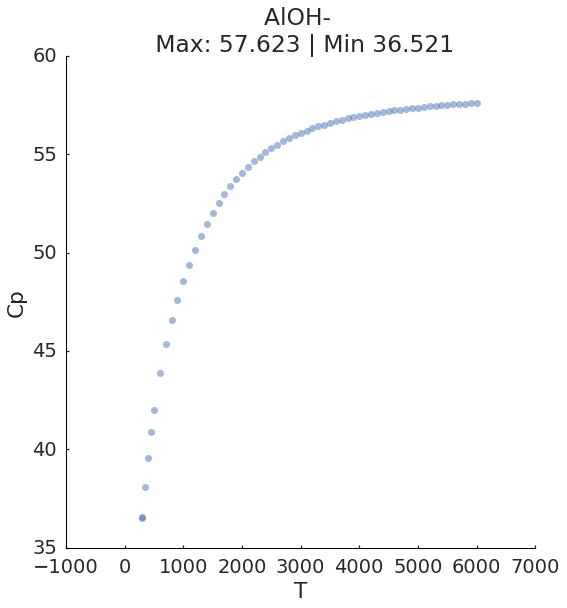

In [29]:
pal = sns.color_palette("muted")

g = sns.lmplot(x='T', y='Cp', data=df_t, fit_reg=False,
               palette=pal, size=8, scatter_kws={"s": 50, "alpha": 0.5})
g.ax.set_title('%s \n Max: %s | Min %s'%(composition, np.max(Cp), np.min(Cp)))

# Ab Initio Solute-Solvent Database Example

In [129]:
params = {
        'q': "dane",
        'count': 10,
        'from': 0
    }
    
r = client.search(**params)

### Data Keys

In [151]:
for key in r.data['gmeta'][0]:
    print(r.data['gmeta'][0][key]['content'].keys())

dict_keys(['_#moments_of_inertia', '_#reciprocal_cell', '_#TESTING', '_#masses', '_#angular_momentum', '_#chemical_symbols', '_#number_of_atoms', '_#potential_energy', '_#positions', '_#total_energy', '_#volume', '_#initial_charges', '_#pbc', '_#cell', '_#all_distances', '_#forces_raw', '_#temperature', '_#chemical_formula', '_#momenta', '_#kinetic_energy', '_#celldisp', '_#initial_magnetic_moments', '_#cell_lengths_and_angles', '_#scaled_positions', '_#center_of_mass', '_#forces', '_#dirs', '_#tags', '_#atomic_numbers'])


### Example result

In [145]:
print(json.dumps(r.data['gmeta'][1], sort_keys=True, indent=4))

{
    "globus://82f1b5c6-6e9b-11e5-ba47-22000b92c6ec/published/publication_164/data/BCC_solute_FeAg_20160524T091201/defect_vac1b_opt": {
        "content": {
            "_#TESTING": "dane_morgan_test1",
            "_#all_distances": [
                [
                    0.0,
                    2.739313157764187,
                    5.634176777782181,
                    2.739313157764187,
                    3.8804487371565677,
                    6.265987725666242,
                    5.634176777782181,
                    6.265987725666241,
                    7.94522922610166,
                    2.739313157764187,
                    3.8804487371565677,
                    6.265987725666242,
                    3.8804487371565677,
                    6.841733704668722,
                    6.265987725666242,
                    6.841733704668722,
                    8.394601935851396,
                    5.634176777782181,
                    6.265987725666241,
                